# ProMis - Probabilistic Mission Design

We will start by importing the necessary tools for the experiments.

In [1]:
# Standard Library
from collections import defaultdict
from multiprocessing import Pool
from os.path import exists
from pickle import Pickler
from pickle import load
from time import sleep

# Third Party
from numpy import eye
from numpy import mean
from overpy.exception import OverpassGatewayTimeout
from overpy.exception import OverpassTooManyRequests
from pandas import concat
import pandas as pd
from scipy.interpolate import SmoothBivariateSpline

# ProMis
from promis.geo import CartesianLocation
from promis.geo import CartesianMap
from promis.geo import LocationType
from promis.geo import PolarLocation
from promis.loaders import OsmLoader
from promis.logic.solvers import MultithreadSolver
from promis.logic.spatial import Distance
from promis.logic.spatial import Over

# Plotting and figure settings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8, 3), 'legend.title_fontsize': 15})
sns.set_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Ignore unimportant warnings in Jupyter
import warnings
warnings.filterwarnings('ignore')

## Utilities

These are utility functions we will use to setup the experiments based on both OSM and simulated data.

In [2]:
def load_map(origin, width, height, timeout=5):
    experiment_map = None

    while not experiment_map:
        try:
            experiment_map = OsmLoader().load_cartesian(origin=origin, width=width, height=height)
        except (OverpassGatewayTimeout, OverpassTooManyRequests):
            print(f"OSM query failed, sleeping {timeout}s...")
            sleep(timeout)

    return experiment_map


def create_artificial_atoms(origin, width, height, resolution):
    start = CartesianLocation(0.0, 0.0, location_type=LocationType.START)
    operator = CartesianLocation(0.0, 0.0, location_type=LocationType.OPERATOR)
    artificial_map = CartesianMap(origin, width, height, [start, operator])

    distances = defaultdict(list)
    distances[LocationType.START].append(Distance.from_map(artificial_map, LocationType.START, resolution, 1))
    distances[LocationType.OPERATOR].append(Distance.from_map(artificial_map, LocationType.OPERATOR, resolution, 1))

    overs = defaultdict(list)

    return distances, overs


def create_atoms(distances, overs, experiment_map, resolution, number_of_random_maps):
    for location_type in LocationType:
        # Load pickle if already exists
        try:
            with open(f"../output/spatial/distance/distance_{experiment_map.width}_{resolution[0]}_{experiment_map.origin.latitude}_{experiment_map.origin.longitude}_{location_type.name.lower()}.pkl", "rb") as pkl_file:
                distance = load(pkl_file)
                distances[location_type].append(distance)
            with open(f"../output/spatial/over/over_{experiment_map.width}_{resolution[0]}_{experiment_map.origin.latitude}_{experiment_map.origin.longitude}_{location_type.name.lower()}.pkl", "rb") as pkl_file:
                over = load(pkl_file)
                overs[location_type].append(over)
        # Else recompute and store results
        except FileNotFoundError:
            # Work on both spatial relations in parallel
            pool = Pool(2)
            distance = pool.apply_async(Distance.from_map, (experiment_map, location_type, resolution, number_of_random_maps))
            over = pool.apply_async(Over.from_map, (experiment_map, location_type, resolution, number_of_random_maps))

            # Append results to dictionaries and export as pkl
            distance_result = distance.get()
            over_result = over.get()
            if distance_result is not None:
                distances[location_type].append(distance_result)
                with open(f"../output/spatial/distance/distance_{experiment_map.width}_{resolution[0]}_{experiment_map.origin.latitude}_{experiment_map.origin.longitude}_{location_type.name.lower()}.pkl", "wb") as file:
                    Pickler(file).dump(distance.get())
            if over_result is not None:
                overs[location_type].append(over_result)
                with open(f"../output/spatial/over/over_{experiment_map.width}_{resolution[0]}_{experiment_map.origin.latitude}_{experiment_map.origin.longitude}_{location_type.name.lower()}.pkl", "wb") as file:
                    Pickler(file).dump(over.get())

## Experiment Settings

These are the conditions for which ProMis will be evaluated.
Make changes to this section in order to experiment with your own logic and conditions.

In [3]:
# The dimensions of the map in meters
width = height = 1000

# The resolutions to evaluate maps for
# For each pair, the pipeline will run once
resolutions = [
    (25, 25),
    (50, 50),
    (75, 75)
]

# How often to split the map into quarters
# For each value, the pipeline will run once
numbers_of_splits = [3, 4, 5]

# An identical uncertainty applied to all map features
covariance = 10.0 * eye(2)

# We will obtain distance and over estimates from these many random maps
number_of_random_maps = 50

# Where to center the map
tu_darmstadt = PolarLocation(latitude=49.878091, longitude=8.654052)  # TU Darmstadt
fehmarn = PolarLocation(latitude=54.421, longitude=11.1927)  # Fehmarn
frankfurt_hbf = PolarLocation(latitude=50.1012, longitude=8.6477)  # Frankfurt HBF
shibuya = PolarLocation(latitude=35.65949, longitude=139.70058)  # Shibuya
origin = tu_darmstadt

# Which model, i.e., logic, to apply
model_names = ["Park", "Rails", "Bay", "Crossing"]

## Apply ProMis

Here we apply ProMis given the previous section's settings.
The relevant data will be loaded, probabilistic spatial relations will be computed and the model checked against the obtained parameters.
Finally, the Probabilistic Mission Landscapes and inference time will be stored in the output folder.
This step will take some time, depending on how many combinations of model, resolution and splits there are as well as the complexity of each individual setting.

In [4]:
# Prepare OSM data
experiment_map = load_map(origin, width, height)
experiment_map.apply_covariance(covariance)

for model_name in model_names:
    with open(f"../models/{model_name}.pl", "r") as model_file:
        model = model_file.read()

    for resolution in resolutions:
        distances, overs = create_artificial_atoms(origin, width, height, resolution)
        create_atoms(distances, overs, experiment_map, resolution, number_of_random_maps)

        for number_of_splits in numbers_of_splits:
            print(f"Inference on {resolution} grid split into {4**number_of_splits} tiles using model {model_name}")
            solver = MultithreadSolver()
            landscapes, inference_time = solver.run_inference(model, distances, overs, number_of_splits)

            # Write landscape to CSV file
            data_frame = concat(landscapes, ignore_index=True)
            data_frame.to_csv(f"../output/landscapes/landscape_{model_name}_{width}_{resolution[0]}_{number_of_splits}.csv", index=False)

            # Write time taken for inference to CSV file
            if not exists(f"../output/data/time.csv"):
                with open(f"../output/data/time.csv", "a") as time_file:
                    time_file.write("Width,Resolution,Tiling,Time / s\n")
                    
            with open(f"../output/data/time.csv", "a") as time_file:
                time_file.write(f"{width}, {resolution[0]}, {number_of_splits}, {inference_time}\n")

Inference on (25, 25) grid split into 64 tiles using model Park
Inference on (25, 25) grid split into 256 tiles using model Park
Inference on (25, 25) grid split into 1024 tiles using model Park
Inference on (50, 50) grid split into 64 tiles using model Park
Inference on (50, 50) grid split into 256 tiles using model Park
Inference on (50, 50) grid split into 1024 tiles using model Park
Inference on (75, 75) grid split into 64 tiles using model Park
Inference on (75, 75) grid split into 256 tiles using model Park
Inference on (75, 75) grid split into 1024 tiles using model Park
From file <promis.logic.spatial.distance.Distance object at 0x7f126c8001c0>
From file <promis.logic.spatial.over.Over object at 0x7f126c801db0>
From file <promis.logic.spatial.distance.Distance object at 0x7f126c801540>
From file <promis.logic.spatial.over.Over object at 0x7f1294421c00>
From file <promis.logic.spatial.distance.Distance object at 0x7f124dc14100>
From file <promis.logic.spatial.over.Over object at

## Inference Error

Here we take a look at the inference error compared to a reference resolution.
For this, at least two distinct resolutions need to be set and evaluated in the cells above.
The reference resolution will be the last one in the list of all resolutions.

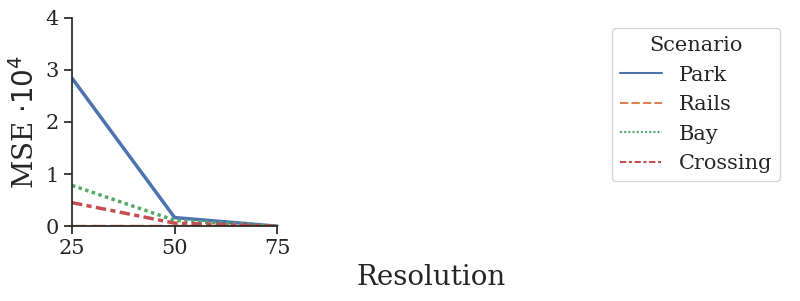

In [5]:
reference_resolution = resolutions[-1]

results = pd.DataFrame(columns=["Model", "Resolution", "MSE"])
for model_name in model_names:
    reference_csv = pd.read_csv(f"../output/landscapes/landscape_{model_name}_{width}_{reference_resolution[0]}_5.csv")
    rxs = reference_csv["latitude"].to_numpy()
    rys = reference_csv["longitude"].to_numpy()
    rzs = reference_csv["probability"].to_numpy()
    reference_spline = SmoothBivariateSpline(rxs, rys, rzs)

    for resolution in resolutions:
        landscape_csv = pd.read_csv(f"../output/landscapes/landscape_{model_name}_{width}_{resolution[0]}_5.csv")
        lxs = landscape_csv["latitude"].to_numpy()
        lys = landscape_csv["longitude"].to_numpy()
        lzs = landscape_csv["probability"].to_numpy()
        landscape_spline = SmoothBivariateSpline(lxs, lys, lzs)

        mse = 1e4 * mean((reference_spline(rxs, rys, grid=False) - landscape_spline(rxs, rys, grid=False))**2)
        results = pd.concat([results, pd.DataFrame(data={"Model": [model_name], "Resolution": [resolution[0]], "MSE": [mse]})], ignore_index=True)

plot = sns.lineplot(data=results, hue="Model", y="MSE", x="Resolution", style="Model", palette=sns.color_palette(), linewidth=2.5)
plt.gca().set_xlim([25, 200])
plt.gca().set_ylim([0, 4])
plt.gca().set_yticks(range(5))
plt.gca().set_xticks([resolution[0] for resolution in resolutions])
plt.gcf().tight_layout()
sns.despine(trim=True, top=True, right=True)

plot.set_xlabel("Resolution", fontsize=20)
plot.set_ylabel("MSE $\cdot 10^4$", fontsize=20)
plot.tick_params(labelsize=15)
plot.legend(title="Scenario", fontsize=15)

plot.get_figure().savefig("../output/figures/error_plot.pdf", bbox_inches='tight')
plot.get_figure().savefig("../output/figures/error_plot.png", bbox_inches='tight')

## Inference Time

Finally, lets take a look at the inference time.
That is, how many seconds it takes for a Probabilistic Mission Landscape to be obtained given its model, resolution and number of splits.

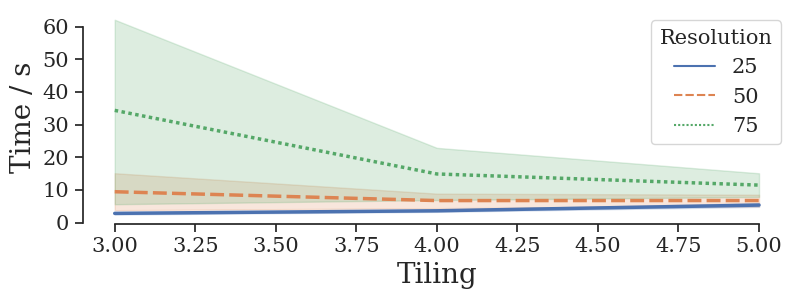

In [6]:
results = pd.read_csv("../output/data/time.csv")
plot = sns.lineplot(data=results, hue="Resolution", y="Time / s", x="Tiling", style="Resolution", palette=sns.color_palette(), linewidth=2.5)
plt.gcf().tight_layout()
sns.despine(trim=True, top=True, right=True)

plot.set_xlabel("Tiling", fontsize=20)
plot.set_ylabel("Time / s", fontsize=20)
plot.tick_params(labelsize=15)
plot.legend(title="Resolution", fontsize=15)

plot.get_figure().savefig("../output/figures/time_plot.pdf", bbox_inches='tight')
plot.get_figure().savefig("../output/figures/time_plot.png", bbox_inches='tight')